# EECS 4415 - Task 1
## Word Count in Spark

### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive2
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out
!mv /usr/local/lib/libtbbmalloc_proxy.so.2 /usr/local/lib/libtbbmalloc_proxy.so.2.backup
!mv /usr/local/lib/libtbbmalloc.so.2 /usr/local/lib/libtbbmalloc.so.2.backup
!mv /usr/local/lib/libtbbbind_2_5.so.3 /usr/local/lib/libtbbbind_2_5.so.3.backup
!mv /usr/local/lib/libtbb.so.12 /usr/local/lib/libtbb.so.12.backup
!mv /usr/local/lib/libtbbbind_2_0.so.3 /usr/local/lib/libtbbbind_2_0.so.3.backup
!mv /usr/local/lib/libtbbbind.so.3 /usr/local/lib/libtbbbind.so.3.backup
!ln -s /usr/local/lib/libtbbmalloc_proxy.so.2.11 /usr/local/lib/libtbbmalloc_proxy.so.2
!ln -s /usr/local/lib/libtbbmalloc.so.2.11 /usr/local/lib/libtbbmalloc.so.2
!ln -s /usr/local/lib/libtbbbind_2_5.so.3.11 /usr/local/lib/libtbbbind_2_5.so.3
!ln -s /usr/local/lib/libtbb.so.12.11 /usr/local/lib/libtbb.so.12
!ln -s /usr/local/lib/libtbbbind_2_0.so.3.11 /usr/local/lib/libtbbbind_2_0.so.3
!ln -s /usr/local/lib/libtbbbind.so.3.11 /usr/local/lib/libtbbbind.so.3
# !sudo ldconfig
#If error related to the above execution occurs, you can try commenting out the above 12 lines under pip install PyDrive2 (not included)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u422-b05-1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u422-b05-1~22.04) ...
Sel

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1SE6k_0YukzGd5wK-E4i6mG83nydlfvSa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('pg100.txt')

If you executed the cells above, you should be able to see the file *pg100.txt* under the "Files" tab on the left panel.

### Your task

If you successfully run the setup stage, you are ready to work on the *pg100.txt* file which contains a copy of the complete works of Shakespeare.

Write a Spark application which outputs the number of words that start with each letter. This means that for every letter, we want to count the total number of (non-unique) words that start with a specific letter. (If a specific (aka unique) word that starts with letter 'a' appears N times, it should be counted in words starting with 'a' N times.)

In your implementation, **ignore the letter case**, i.e., consider all words as lower case. Also, ignore all words that **start** with a non-alphabetic character. You should output word counts for the **entire document**, inclusive of the title, author, and the main texts. If you encounter words broken as a result of new lines, e.g. "pro-ject" where the segment after the dash sign is on a new line, no special processing is needed and you can safely consider it as two words ("pro" and "ject").

Your outputs will be graded on a range -- if your differences from the ground-truths are within an error threshold of 5, you'll be considered correct.

**Hint:**
1. split only on space (' ') but not hyphen/dash ('-') or other symbols.
2. you may find spark function split (https://spark.apache.org/docs/latest/rdd-programming-guide.html) helpful, but you don't need to restrict to them as long as you can satisfy your goal.

Clarification:

1. If a word 'project' is separated into two lines in the form of 'pro-' in the first line and 'ject' in the second line, it should be treated as two words. However, for the word 'self-love' that appears in a single line, it should be treated as one word starting with letter 's'.

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

Perform map and reduce operations using Spark transformations and actions. See the following programming guide for these transformations and actions (among other resources that you can find online): https://spark.apache.org/docs/latest/rdd-programming-guide.html).

In [ ]:
# YOUR CODE HERE (map operations)
# Read the text file
text_file = sc.textFile("pg100.txt")

# Split each line into words based on spaces
words = text_file.flatMap(lambda line: line.split(' '))

# Clean and filter words
def clean_word(word):
    # Strip leading/trailing whitespace and convert to lowercase
    word = word.strip().lower()
    # Check if word starts with an alphabetic character
    if len(word) > 0 and word[0].isalpha():
        return word
    else:
        return None

# Apply the cleaning function and filter out None values
words_cleaned = words.map(clean_word).filter(lambda word: word is not None)

# Map each word to (first_letter, 1)
letters = words_cleaned.map(lambda word: (word[0], 1))

In [ ]:
# YOUR CODE HERE (reduce operations)
# Reduce by key (first_letter) to get counts per letter
counts = letters.reduceByKey(lambda a, b: a + b)

Compute and print for words that start with a, d, e, j, k, n, q, t, y, z

In [ ]:
# YOUR CODE HERE
# Collect the counts to the driver as a dictionary
counts_dict = counts.collectAsMap()

# Specify the letters of interest
selected_letters = ['a', 'd', 'e', 'j', 'k', 'n', 'q', 't', 'y', 'z']

# Print counts for the selected letters
for letter in selected_letters:
    count = counts_dict.get(letter, 0)
    print(f"Letter '{letter}': {count}")

Letter 'a': 84836
Letter 'd': 29713
Letter 'e': 18697
Letter 'j': 3339
Letter 'k': 9418
Letter 'n': 26759
Letter 'q': 2377
Letter 't': 123602
Letter 'y': 25855
Letter 'z': 71


Make a plot based on this printed data.

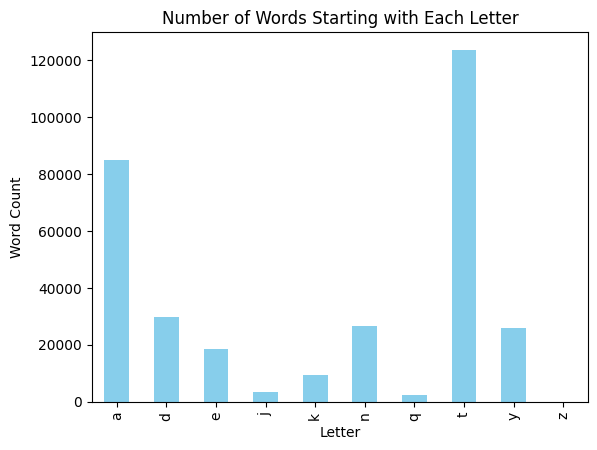

In [ ]:
#YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt

# Collect the counts to the driver as a dictionary
counts_dict = counts.collectAsMap()

# Specify the letters of interest
selected_letters = ['a', 'd', 'e', 'j', 'k', 'n', 'q', 't', 'y', 'z']

# Create a DataFrame from the selected counts
selected_counts = {letter: counts_dict.get(letter, 0) for letter in selected_letters}
df = pd.DataFrame(list(selected_counts.items()), columns=['letter', 'count'])

# Sort the DataFrame by letter
df = df.sort_values('letter')

# Plot the data
df.plot.bar(x='letter', y='count', legend=False, color='skyblue')
plt.title('Number of Words Starting with Each Letter')
plt.xlabel('Letter')
plt.ylabel('Word Count')
plt.show()

Write a paragraph of conclusions below summarizing your insights.

From our analysis, we found that words starting with ‘t’ and ‘a’ are the most frequent in Shakespeare’s works, largely due to common words like “the” and “and”, while letters like ‘q’, ‘z’, and ‘j’ are the least frequent. Utilizing Spark enabled us to efficiently process the large text file, demonstrating its strength in handling big data tasks through distributed computing. Spark’s powerful transformations and actions simplified the data processing, allowing us to perform complex analyses with concise code. This exercise highlights both linguistic patterns in English literature and the effectiveness of Spark for large-scale text analysis.

Once you obtained the desired results, **head over to eClass and submit your solution for this Colab**!